### Imports

In [319]:
# %matplotlib qt5
import pandas as pd
import numpy as np
import os
import sys
from pickle import load
import matplotlib.pyplot as plt

### Preprocesamiento de los datos

In [320]:
print('Running preprocessing...')

# Manejo de archivos
file_name = "\Hands_on_tool.xlsx"
# file_name = str(sys.argv[1])  #Si queremos usarlo como argumento
DATA_DIR = "\Raw_Data"
RESULTS_DIR = "\Results"
current_dir = os.getcwd()
Rutabase = os.path.abspath(os.path.join(current_dir, os.pardir))
Rutarel_in = DATA_DIR + file_name
excel_filename = Rutabase + Rutarel_in
print('Analyzing document: ',excel_filename)

# Se importan los datos
data = pd.read_excel(excel_filename)
df = pd.DataFrame(data, columns= ['VISUAL_ID', 'WITHIN_SESSION_SEQUENCE_NUMBER',
                                'WITHIN_SESSION_LATEST_FLAG', 'INTERFACE_BIN',
                                'TESTER_INTERFACE_UNIT_ID', 'MODULE', 'SITE_ID', 'TEST_TIME',
                                'DEVICE_END_DATE_TIME', 'LOT'])
# Ordenamos por fecha y hora
df = df.sort_values(by=['DEVICE_END_DATE_TIME'])
df = df.reset_index(drop=True)
df.shape

#### Filtrado de bines sólidos y conteo de bines por colateral general y por lote
# Recorremos el array para ver sólidos y los eliminaremos de la lista (lista nueva llamada df_Switching)
Solid_visual = []
SV1 = []
SV3 = []
SV5 = []

Current_retest_index = []
df = df.sort_values(by=['VISUAL_ID','WITHIN_SESSION_SEQUENCE_NUMBER'])          # Ordenamos por visual y número de secuencia
df_Switching = df.copy()
diferent_flag = 0
bin_switch_flag = 0
prev_visual = ''
prev_bin = 0
current_bin = 0
current_visual = ''
total_units = 0

print('Buscando unidades sólidas!')
# Recorremos los datos
for index, row in df.iterrows():
    prev_bin = current_bin
    prev_visual = current_visual

    current_visual = row["VISUAL_ID"]
    current_bin = row["INTERFACE_BIN"]
    
    if prev_visual != current_visual:
        diferent_flag = 1
    else:
        diferent_flag = 0
    
    # Nueva unidad
    if diferent_flag == 1:
        prev_bin = 0
        total_units = total_units + 1
        bin_switch_flag = 0
        
        if(current_bin == 1):
            # Unidades buenas, no las tomamos en cuenta
            if(row['MODULE'] == 'HXV101'):
                SV1.append(current_visual)
            elif(row['MODULE'] == 'HXV103'):
                SV3.append(current_visual)
            elif(row['MODULE'] == 'HXV105'):
                SV5.append(current_visual)
        else:
            # Unidad de retest, hay que analizar
            Current_retest_index.append(index)

    # Unidad de retest
    if diferent_flag == 0:
        Current_retest_index.append(index)

        # Es fallo sólido
        if (prev_bin == current_bin) and (bin_switch_flag == 0) and (row['WITHIN_SESSION_LATEST_FLAG'] == 'Y'):
            Current_retest_index.clear()                                # Vaciamos buffer de index
            if(row['MODULE'] == 'HXV101'):
                SV1.append(current_visual)
            elif(row['MODULE'] == 'HXV103'):
                SV3.append(current_visual)
            elif(row['MODULE'] == 'HXV105'):
                SV5.append(current_visual)

        # Es bin Switch
        if (prev_bin != current_bin) or (bin_switch_flag == 1):
            bin_switch_flag = 1                                     # Prendemos bandera para que no se confunda con solidas
            if (row["WITHIN_SESSION_LATEST_FLAG"] == 'Y') :
                Current_retest_index.clear()                        # Vaciamos el buffer de index
Solid_visual = [SV1, SV3, SV5]
print('Se van a ignorar: ', int(len(Solid_visual[0])+int(len(Solid_visual[1]))+int(len(Solid_visual[2]))), ' líneas que son unidades sólidas.')
df_Switching = df
df_Switching.shape

# Contamos "socketing" por colateral y promedio de test time
df_Switching_Backup = df_Switching.copy()
# Dataframe de salida del preprocesamiento de datos y entrada del algoritmo de ML
df_final = pd.DataFrame(columns=['Socketing', 'TIU', 'Tool', 'Cell',
    'Test_Time', 'Bines_General', 'Bines_NLot',
    '1' , '2', '3', '4', '5', '6', '7', '8', '9', '10',
    '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
    '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
    '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
    '41', '42', '43', '44', '45', '46', '47', '48', '49', '50',
    '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
    '61', '62', '63', '64', '65', '66', '67', '68', '69', '70',
    '71', '72', '73', '74', '75', '76', '77', '78', '79', '80',
    '81', '82', '83', '84', '85', '86', '87', '88', '89', '90',
    '91', '92', '93', '94', '95', '96', '97', '98', '99'])  

# Listas de maquinas y celdas donde se busca la información de performance por colateral.
Tool_Number = ['HXV101', 'HXV103', 'HXV105']

Cell_Number = ['A101', 'A102', 'A201', 'A202', 'A301', 'A302', 'A401', 'A402', 'A501', 'A502',
            'B101', 'B102', 'B201', 'B202', 'B301', 'B302', 'B401', 'B402', 'B501', 'B502', 
            'C101', 'C102', 'C201', 'C202', 'C301', 'C302', 'C401', 'C402', 'C501', 'C502']

n = 0       # Indice de fila a rellenar
prev_TIU = ''
current_TIU = ''
counter =0

# Recorremos el array para cada tool
for Tool in Tool_Number:

    print('Analizing tool ', Tool, '...')
    df_tool = df[df.MODULE.isin([Tool])]
    df_Switching_tool = df_Switching_Backup[df_Switching_Backup.MODULE.isin([Tool])]

    # Iteración por celda
    for Cell in Cell_Number:  
        # print('Analizing cell ', Cell, '...')
        df_celda = df_tool[df_tool.SITE_ID.isin([Cell])]
        df_Switching = df_Switching_tool[df_Switching_tool.SITE_ID.isin([Cell])]

        df_TIU = df_celda
        df_TIU = df_TIU.sort_index()
        df_Switching = df_Switching.sort_index()
        current_TIU_socketing = 1
        test_time_prom = 0
        DUT_index = []          #Aqui guardo los indices de la TIU que estamos analizando para luego sacar muestras buenas.
        solid_search = 0        # To change search of solid visual between tools

        # Recorremos el array y detectamos cambios de colateral (que suponemos como marginalidad)
        for index, row in df_TIU.iterrows():
            prev_LOT = ''
            current_LOT = ''
            Lot_History = [0]
            prev_TIU = current_TIU
            current_TIU = row['TESTER_INTERFACE_UNIT_ID']
            current_Test_time= row['TEST_TIME']
            current_date = row['DEVICE_END_DATE_TIME']

            test_time_prom = test_time_prom + current_Test_time

            # Seguimos en el mismo colateral
            if prev_TIU == current_TIU:
                DUT_index.append(index)
                current_TIU_socketing = current_TIU_socketing + 1

            # Diferente colateral, nueva fila
            elif (prev_TIU != current_TIU) and (prev_TIU != ''):
                test_time_prom = 0
                current_TIU_socketing = 1
                reg_index = []

        # Temporalmente terminamos con un cierto colateral que suponemos como bueno
        df_final.loc[str(n)] = np.zeros(106)
        df_final.loc[str(n),'Socketing'] = current_TIU_socketing
        df_final.loc[str(n), 'TIU'] = current_TIU[-5:]
        df_final.loc[str(n), 'Test_Time'] = round(test_time_prom / current_TIU_socketing, 3)
        df_final.loc[str(n), 'Tool'] = Tool
        df_final.loc[str(n), 'Cell'] = Cell
        a_flag = 1
        prev_LOT = ''
        current_LOT = ''
        Lot_History = [0]
        reg_index = []

        # Buscamos bines 
        for index_2, row_2 in df_Switching.iterrows():
            counter += 1
            prev_LOT = current_LOT
            current_LOT = row_2['LOT']
            
            if (row_2['TESTER_INTERFACE_UNIT_ID'] == prev_TIU) and (a_flag == 1):
                reg_index.append(index_2)

                if(str(row_2['VISUAL_ID']) not in Solid_visual[solid_search]):

                    df_final.loc[str(n), str(int(row_2['INTERFACE_BIN']))] += 1             # sumamos a los bines 
                    df_final.loc[str(n), 'Bines_General'] += 1                              # Sumamos al historial general de bines
                    
                    # Verificamos por lote (hacer promedio por lote)
                    if(current_LOT == prev_LOT):
                        Lot_History[-1] += 1                # Sumamos a los bines de un mismo lote
                    else:
                        Lot_History.append(1)               # Agregamos un lote nuevo
                else:
                    Solid_visual[solid_search].remove(str(row_2['VISUAL_ID']))                        # Eliminamos el visual que ya fue consultado
            else:
                a_flag = 0
        df_final.loc[str(n), 'Bines_NLot'] = round(sum(Lot_History)/len(Lot_History), 3)             # Metemos el promedio de bines de fallo por lote
        test_time_prom = 0
        df_Switching_Backup = df_Switching_Backup.drop(reg_index)
        df_Switching = df_Switching.drop(reg_index)
        n = n+1
        current_TIU_socketing = 1
        prev_TIU = ''
        current_TIU = ''
    solid_search = solid_search + 1
    print("Done!")
    
total_analized = df_final['Socketing'].sum()
df_final


Running preprocessing...
Analyzing document:  c:\Users\felip\Documents\Universidad\1s2022\Proyecto_Electrico\Source\Raw_Data\Hands_on_tool.xlsx
Buscando unidades sólidas!
Se van a ignorar:  237901  líneas que son unidades sólidas.
Analizing tool  HXV101 ...
Done!
Analizing tool  HXV103 ...
Done!
Analizing tool  HXV105 ...
Done!


,Socketing,TIU,Tool,Cell,Test_Time,Bines_General,Bines_NLot,1,2,3,...,90,91,92,93,94,95,96,97,98,99
0,2316.0,P3763,HXV101,A101,153.280,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96.0,13824,HXV101,A102,179.509,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2824.0,P3674,HXV101,A201,154.545,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.0,P3844,HXV101,A202,114.963,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,251.0,P4066,HXV101,A301,181.268,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1576.0,P3963,HXV105,C302,173.487,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,2271.0,P3666,HXV105,C401,169.502,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,2544.0,P3979,HXV105,C402,169.745,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,4232.0,P3838,HXV105,C501,172.885,4232.0,17.134,3926.0,0.0,0.0,...,1.0,0.0,1.0,0.0,48.0,0.0,0.0,0.0,3.0,2.0


In [321]:
# Se les da forma a los datos para se analizados (necesario en modelos dinámicos)
# file_name = "\ML_input.xlsx"
# RESULTS_DIR = "\Results"
# current_dir = os.getcwd()
# Rutarel = RESULTS_DIR + file_name
# excel_filename = Rutabase + Rutarel
# # Se importan los datos
# data1 = pd.read_excel(excel_filename, nrows=1)
# data1 = data1.drop(['G/B_flag'],axis=1)
# correct_head = data1.columns

# Columnas de datos con los que se entrenó al modelo de ML
correct_head = ['Socketing', 'Test_Time', 'Bines_General', 'Bines_NLot', '8', '9', '10',
       '11', '13', '15', '18', '19', '27', '28', '31', '35', '41', '42', '43',
       '44', '46', '47', '51', '54', '56', '60', '62', '64', '68', '92', '94',
       '97', '98', '99', '53']

evaluation_df = pd.DataFrame(columns=correct_head)
fila = []
for index, row in df_final.iterrows():
	for head in correct_head:
		fila.append(row[head])
	evaluation_df.loc[index] = fila
	fila = []
evaluation_df

,Socketing,Test_Time,Bines_General,Bines_NLot,8,9,10,11,13,15,...,60,62,64,68,92,94,97,98,99,53
0,2316.0,153.280,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96.0,179.509,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2824.0,154.545,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.0,114.963,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,251.0,181.268,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1576.0,173.487,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,2271.0,169.502,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,2544.0,169.745,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,4232.0,172.885,4232.0,17.134,13.0,9.0,3.0,2.0,23.0,6.0,...,1.0,0.0,1.0,7.0,1.0,48.0,0.0,3.0,2.0,0.0


In [322]:
# Se estandarizan los datos
Scaler = load(open('scaler.pkl', 'rb'))
evaluation_df = pd.DataFrame(Scaler.fit_transform(evaluation_df), columns=correct_head)
evaluation_df


,Socketing,Test_Time,Bines_General,Bines_NLot,8,9,10,11,13,15,...,60,62,64,68,92,94,97,98,99,53
0,0.469479,0.697752,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
1,0.019266,0.817150,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
2,0.572501,0.703510,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
3,0.001217,0.523327,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
4,0.050700,0.825157,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.319408,0.789737,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
86,0.460353,0.771596,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
87,0.515717,0.772703,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0
88,0.858041,0.786996,0.951011,0.277222,0.619048,0.5625,0.5,0.2,0.159722,0.5,...,0.5,0.0,0.25,1.0,0.333333,0.571429,0.0,0.75,0.071429,0.0


### Model

In [323]:
# Cargamos los modelos
classifier_multinomial = load(open('model_MULT.pkl', 'rb'))
classifier_gaussian = load(open('model_GAUS.pkl', 'rb'))
classifier_bernuilli = load(open('model_BERNU.pkl', 'rb'))

# Realizamos la predicción
prediccion_gau = classifier_gaussian.predict(evaluation_df)
prediccion_multi = classifier_multinomial.predict(evaluation_df)
prediccion_bernu = classifier_bernuilli.predict(evaluation_df)
print('GAUSSIAN:')
print(prediccion_gau)
print('MULTINOMIAL:')
print(prediccion_multi)
print('BERNUILLI')
print(prediccion_bernu)

GAUSSIAN:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1]
MULTINOMIAL:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1]
BERNUILLI
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1]


### Visualizacion de resultados

In [330]:

###### Modelo Elegido #######
#############################
ChoosenOne = prediccion_multi
#############################

# Para rearmar los indices en la visualización
indexing1 = [0,1,10,11,20,21]   # A101, A102, B101, B102, C101, C102
indexing2 = [2,3,12,13,22,23]   # A201, A202, B201, B202, C201, C202
indexing3 = [4,5,14,15,24,25]   # A301, A302, B301, B302, C301, C302
indexing4 = [6,7,16,17,26,27]   # A401, A402, B401, B402, C401, C402
indexing5 = [8,9,18,19,28,29]   # A501, A502, B501, B502, C501, C502
t101 = []
t103 = []
t105 = []
counter = 0

# Segregamos y acomodamos los datos segun máquina
for i in range(30):
    t101.append(ChoosenOne[i])
    t103.append(ChoosenOne[i+30])
    t105.append(ChoosenOne[i+60])
Matriz_101 = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
Matriz_103 = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
Matriz_105 = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
counter = 0
for i in indexing5:
    Matriz_101[0][counter]=t101[i]
    Matriz_103[0][counter]=t103[i]
    Matriz_105[0][counter]=t105[i]
    counter +=1
counter = 0
for i in indexing4:
    Matriz_101[1][counter]=t101[i]
    Matriz_103[1][counter]=t103[i]
    Matriz_105[1][counter]=t105[i]
    counter +=1
counter = 0
for i in indexing3:
    Matriz_101[2][counter]=t101[i]
    Matriz_103[2][counter]=t103[i]
    Matriz_105[2][counter]=t105[i]
    counter +=1
counter = 0
for i in indexing2:
    Matriz_101[3][counter]=t101[i]
    Matriz_103[3][counter]=t103[i]
    Matriz_105[3][counter]=t105[i]
    counter +=1
counter = 0
for i in indexing1:
    Matriz_101[4][counter]=t101[i]
    Matriz_103[4][counter]=t103[i]
    Matriz_105[4][counter]=t105[i]
    counter +=1

print('HXV101: ', Matriz_101)
print('HXV103: ', Matriz_103)
print('HXV105: ', Matriz_105)


HXV101:  [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0]]
HXV103:  [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1]]
HXV105:  [[1, 1, 1, 1, 0, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 1], [0, 1, 1, 1, 1, 0], [0, 0, 1, 1, 1, 1]]


#### Gráficas

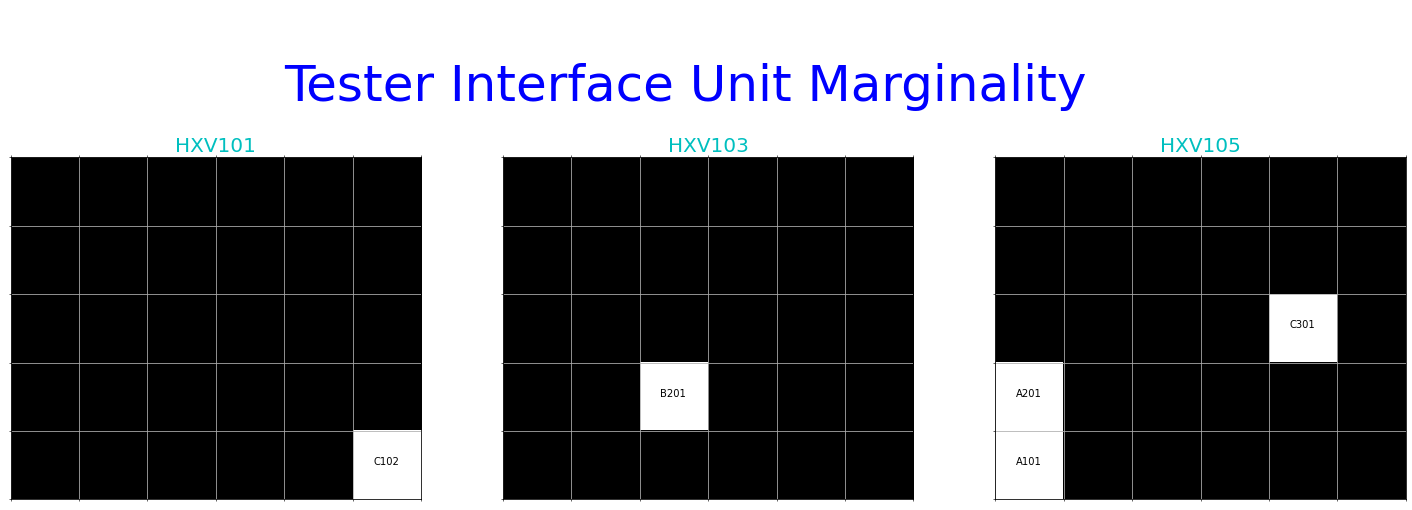

In [329]:
fig = plt.figure(figsize=(25,15))
fig.suptitle('\nTester Interface Unit Marginality\n', fontsize=50, y=0.8, color='b')
matriz_1 = pd.DataFrame(Matriz_101)
plt.subplot(131)
plt.matshow(matriz_1, cmap='Greys',vmin=0, fignum=False, vmax=1)
plt.title('HXV101', fontsize=20, color='c')
plt.text(-0.2, 0, 'A501');plt.text(0.8, 0, 'A502');plt.text(1.8, 0, 'B501');plt.text(2.8, 0, 'B502');plt.text(3.8, 0, 'C501');plt.text(4.8, 0, 'C502')
plt.text(-0.2, 1, 'A401');plt.text(0.8, 1, 'A402');plt.text(1.8, 1, 'B401');plt.text(2.8, 1, 'B402');plt.text(3.8, 1, 'C401');plt.text(4.8, 1, 'C402')
plt.text(-0.2, 2, 'A301');plt.text(0.8, 2, 'A302');plt.text(1.8, 2, 'B301');plt.text(2.8, 2, 'B302');plt.text(3.8, 2, 'C301');plt.text(4.8, 2, 'C302')
plt.text(-0.2, 3, 'A201');plt.text(0.8, 3, 'A202');plt.text(1.8, 3, 'B201');plt.text(2.8, 3, 'B202');plt.text(3.8, 3, 'C201');plt.text(4.8, 3, 'C202')
plt.text(-0.2, 4, 'A101');plt.text(0.8, 4, 'A102');plt.text(1.8, 4, 'B101');plt.text(2.8, 4, 'B102');plt.text(3.8, 4, 'C101');plt.text(4.8, 4, 'C102')
plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
plt.xticks([])
plt.yticks([])
plt.grid(which='minor')

matriz_3 = pd.DataFrame(Matriz_103)
plt.subplot(132)
plt.matshow(matriz_3, cmap='Greys', vmin=0, fignum=False, vmax=1)
plt.title('HXV103', fontsize=20, color='c')
plt.text(-0.2, 0, 'A501');plt.text(0.8, 0, 'A502');plt.text(1.8, 0, 'B501');plt.text(2.8, 0, 'B502');plt.text(3.8, 0, 'C501');plt.text(4.8, 0, 'C502')
plt.text(-0.2, 1, 'A401');plt.text(0.8, 1, 'A402');plt.text(1.8, 1, 'B401');plt.text(2.8, 1, 'B402');plt.text(3.8, 1, 'C401');plt.text(4.8, 1, 'C402')
plt.text(-0.2, 2, 'A301');plt.text(0.8, 2, 'A302');plt.text(1.8, 2, 'B301');plt.text(2.8, 2, 'B302');plt.text(3.8, 2, 'C301');plt.text(4.8, 2, 'C302')
plt.text(-0.2, 3, 'A201');plt.text(0.8, 3, 'A202');plt.text(1.8, 3, 'B201');plt.text(2.8, 3, 'B202');plt.text(3.8, 3, 'C201');plt.text(4.8, 3, 'C202')
plt.text(-0.2, 4, 'A101');plt.text(0.8, 4, 'A102');plt.text(1.8, 4, 'B101');plt.text(2.8, 4, 'B102');plt.text(3.8, 4, 'C101');plt.text(4.8, 4, 'C102')
plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
plt.xticks([])
plt.yticks([])
plt.grid(which='minor')
plt.subplot(133)
matriz_5 = pd.DataFrame(Matriz_105)
plt.matshow(matriz_5, cmap='Greys', vmin=0, fignum=False, vmax=1)
plt.title('HXV105', fontsize=20, color='c')
plt.text(-0.2, 0, 'A501');plt.text(0.8, 0, 'A502');plt.text(1.8, 0, 'B501');plt.text(2.8, 0, 'B502');plt.text(3.8, 0, 'C501');plt.text(4.8, 0, 'C502')
plt.text(-0.2, 1, 'A401');plt.text(0.8, 1, 'A402');plt.text(1.8, 1, 'B401');plt.text(2.8, 1, 'B402');plt.text(3.8, 1, 'C401');plt.text(4.8, 1, 'C402')
plt.text(-0.2, 2, 'A301');plt.text(0.8, 2, 'A302');plt.text(1.8, 2, 'B301');plt.text(2.8, 2, 'B302');plt.text(3.8, 2, 'C301');plt.text(4.8, 2, 'C302')
plt.text(-0.2, 3, 'A201');plt.text(0.8, 3, 'A202');plt.text(1.8, 3, 'B201');plt.text(2.8, 3, 'B202');plt.text(3.8, 3, 'C201');plt.text(4.8, 3, 'C202')
plt.text(-0.2, 4, 'A101');plt.text(0.8, 4, 'A102');plt.text(1.8, 4, 'B101');plt.text(2.8, 4, 'B102');plt.text(3.8, 4, 'C101');plt.text(4.8, 4, 'C102')
plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
plt.xticks([])
plt.yticks([])
plt.grid(which='minor')
plt.show()
